In [55]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

#diplay preferences
%matplotlib inline
pd.options.display.float_format = '{: .3f}'.format

#suppress harmless error
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [25]:
#using the weather history data from Kaggle
#https://www.kaggle.com/budincsevity/szeged-weather/version/1
weather = pd.read_csv('C:/Users/yakan/OneDrive/Documents/Thinkful/DS_Bootcamp/U3/weatherHistory.csv')

In [8]:
#data.drop('Unnamed: 0', axis = 1, inplace = True)

In [26]:
weather.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


In [27]:
#rename dataet columns to make them easier to type
weather.rename(columns = {weather.columns[0]: 'date',
                          weather.columns[1]: 'summary',
                          weather.columns[2]: 'precip_type',
                          weather.columns[3]: 'temp',
                          weather.columns[4]: 'apparent_temp',
                          weather.columns[5]: 'humidity',
                          weather.columns[6]: 'wind_speed',
                          weather.columns[7]: 'wind_bearing',
                          weather.columns[8]: 'visibility',
                          weather.columns[9]: 'cloud_cover',
                          weather.columns[10]: 'pressure',
                          weather.columns[11]: 'daily_summary'}, inplace = True)

### The goal is to predict humidity using linear regression and KNN regression and compare the predictability of the models.

We are also not going to use the follwing fields: date, summary, precip_type, cloud_cover, daily_summary.

#### Linear Regression

In [30]:
#check to see if any of the variables are highly correlated
corr_matrix = weather[['temp', 'apparent_temp', 'wind_speed', 'wind_bearing', 'visibility', 
                       'pressure']].corr()
print(corr_matrix)

                temp  apparent_temp  wind_speed  wind_bearing  visibility  \
temp           1.000          0.993       0.009         0.030       0.393   
apparent_temp  0.993          1.000      -0.057         0.029       0.382   
wind_speed     0.009         -0.057       1.000         0.104       0.101   
wind_bearing   0.030          0.029       0.104         1.000       0.048   
visibility     0.393          0.382       0.101         0.048       1.000   
pressure      -0.005         -0.000      -0.049        -0.012       0.060   

               pressure  
temp             -0.005  
apparent_temp    -0.000  
wind_speed       -0.049  
wind_bearing     -0.012  
visibility        0.060  
pressure          1.000  


There is quite a high correlation between 'temp' and 'apparent_temp', which is not at all surprising, but we will just use one of the two in the models. We will use 'temp' and leave 'apparent_temp' out.

In [31]:
weather_subset = weather[['temp', 'wind_speed', 'wind_bearing', 'visibility', 
                       'pressure', 'humidity']]

#### Check to see if the relationship between the variables and the outcome 'humidity' is linear.

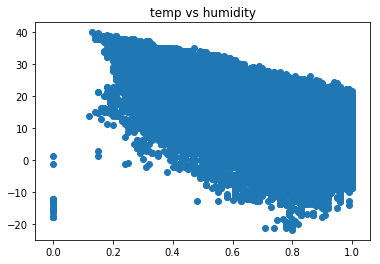

In [38]:
plt.scatter(weather_subset['humidity'], weather_subset['temp'])
plt.title('temp vs humidity')
plt.show()

Here the relationship does appear mostly (negatively) linear, with some outliers in the lower left.

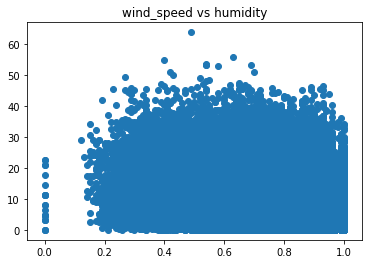

In [39]:
plt.scatter(weather_subset['humidity'], weather_subset['wind_speed'])
plt.title('wind_speed vs humidity')
plt.show()

The relationship here is not really linear - it might make sense to try and transform wind_speed or leave it out.

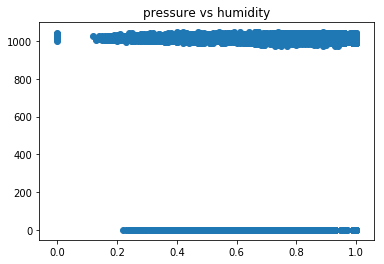

In [46]:
plt.scatter(weather_subset['humidity'], weather_subset['pressure'])
plt.title('pressure vs humidity')
plt.show()

In [52]:
#here it makes to recode the pressure to 'low' and 'high' and use that in the model
weather_subset['pressure_hi_lo'] = weather_subset['pressure'].apply(lambda x: 'low' if x < 1 else 'high')

c:\users\yakan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
linear_Y = weather_subset['humidity']
linear_X = weather_subset[['temp', 'wind_speed', 'wind_bearing', 'visibility', 'pressure']]

In [54]:
#test the model with 20% holdout group
regr = linear_model.LinearRegression()
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(linear_X, linear_Y, 
                                                    test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_train, y_train)))
print('Testing on Sample: ' + str(regr.score(X_test, y_test)))
#score is the R2 values

With 20% Holdout: 0.4621509322006266
Testing on Sample: 0.46012373320214295


#### KNN

In [56]:
from sklearn.neighbors import KNeighborsRegressor

In [57]:
#make a train and test dataset from weather_subset
knn_Y = weather_subset['humidity']
knn_X = weather_subset[['temp', 'wind_speed', 'wind_bearing', 'visibility', 'pressure']]

In [58]:
#test the model with 20% holdout group
knn_reg = KNeighborsRegressor(n_neighbors = 5)
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(knn_X, knn_Y, 
                                                    test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(knn_reg.fit(X_train, y_train).score(X_train, y_train)))
print('Testing on Sample: ' + str(knn_reg.score(X_test, y_test)))
#score is the R2 values

With 20% Holdout: 0.745975139333541
Testing on Sample: 0.6138554102816679
